# Exploratory data analysis on raw dataset

In [4]:
import os

import contextily as cx
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from shapely.geometry import box
from windrose import WindroseAxes
from adjustText import adjust_text

import utils.constants as c
from utils.data_utils import (
    load_dataset,
    load_metadata,
    get_wind_dir_relative_freq,
    get_stations_in_sec_rel_freq,
)
from data.preprocessing import add_temporal_features, transform_wind_direction

if "notebooks" in os.getcwd():
    os.chdir("..")

In [5]:
# Comment out for latex style font rendering (you need it installed on your system)
# mpl.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Latin Modern Roman"],
#     "axes.labelsize": 14,
#     "font.size": 16,
#     "legend.fontsize":12,
#     "xtick.labelsize": 12,
#     "ytick.labelsize": 12,
#     "text.latex.preamble": r"\usepackage{amsmath}",
# })

In [6]:
df_complete_dataset = load_dataset()
df_station_metadata = load_metadata()

## Basic information of dataset

In [8]:
df_complete_dataset.describe()

,air_pressure_00342,air_pressure_00656,air_pressure_00662,air_pressure_00691,air_pressure_00701,air_pressure_00704,air_pressure_00891,air_pressure_00963,air_pressure_01503,air_pressure_01544,...,wind_speed_01691,wind_speed_01766,wind_speed_01975,wind_speed_02014,wind_speed_02115,wind_speed_03093,wind_speed_03631,wind_speed_04745,wind_speed_07367,wind_speed_07374
count,326501.000000,328294.000000,328270.000000,328373.000000,326529.000000,326400.000000,328176.000000,328633.000000,328438.000000,328959.000000,...,325382.000000,328686.000000,326877.000000,327342.000000,269265.000000,307331.000000,325647.000000,326531.000000,320838.000000,328464.000000
mean,1002.938317,944.336467,1005.695603,1014.461124,1014.091352,1013.519155,1013.100892,1010.144932,1014.179294,1009.952369,...,3.078073,3.305820,4.105397,3.858846,6.944337,2.766371,6.056687,3.245694,2.769184,3.435272
std,10.068572,9.064489,9.772614,10.340625,10.561068,10.439294,10.664730,10.184756,10.486733,9.760119,...,2.094030,2.163515,2.266906,2.161852,3.389521,1.729957,3.021317,1.882899,1.679457,1.964170
min,960.000000,906.800000,965.400000,972.200000,971.800000,971.900000,971.100000,967.200000,971.000000,970.600000,...,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.100000,0.000000,0.000000,0.000000
25%,997.000000,939.300000,999.900000,1008.200000,1007.600000,1007.100000,1006.600000,1004.100000,1007.800000,1004.100000,...,1.400000,1.700000,2.400000,2.200000,4.400000,1.500000,3.900000,1.800000,1.500000,2.000000
50%,1003.800000,945.600000,1006.400000,1015.300000,1015.000000,1014.400000,1014.100000,1011.000000,1015.100000,1010.700000,...,2.700000,2.900000,3.800000,3.500000,6.500000,2.400000,5.500000,3.000000,2.600000,3.100000
75%,1009.600000,950.500000,1012.100000,1021.200000,1021.100000,1020.400000,1020.100000,1016.800000,1021.100000,1016.300000,...,4.300000,4.500000,5.500000,5.100000,9.000000,3.700000,7.700000,4.400000,3.800000,4.600000
max,1034.900000,972.100000,1037.200000,1046.700000,1047.100000,1046.400000,1046.800000,1042.400000,1046.500000,1041.600000,...,22.600000,25.000000,18.400000,20.400000,25.200000,14.900000,25.800000,17.200000,14.200000,19.000000


In [9]:
df_complete_dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 329041 entries, 2017-09-28 00:00:00 to 2023-12-31 00:00:00
Columns: 120 entries, air_pressure_00342 to wind_speed_07374
dtypes: float64(120)
memory usage: 303.8 MB


## Missing values

Count missing total missing values

In [10]:
total_number_of_values = df_complete_dataset.size
total_number_of_missing_values = df_complete_dataset.isna().sum().sum()
percentage_of_missing_values = (
    total_number_of_missing_values / total_number_of_values
) * 100

print(f"Total number of values: {total_number_of_values}")
print(f"Total number of missing values: {total_number_of_missing_values}")
print(f"Percentage of missing values: {percentage_of_missing_values}")

Total number of values: 39484920
Total number of missing values: 505004
Percentage of missing values: 1.278979417965137


Count missing values per column

In [11]:
number_of_missing_values_per_column = df_complete_dataset.isna().sum()
percentage_of_missing_values_per_column = (
    number_of_missing_values_per_column / len(df_complete_dataset)
) * 100

missing_values_per_column_stats = pd.DataFrame(
    {
        "Missing Count": number_of_missing_values_per_column,
        "Missing Percent": percentage_of_missing_values_per_column,
    }
)

print("Missing values for each column (10 columns with the highest ratio of missing values):")
print(missing_values_per_column_stats.sort_values(by="Missing Percent", ascending=False)[:10])

Missing values for each column (10 columns with the highest ratio of missing values):
                         Missing Count  Missing Percent
wind_speed_02115                 59776        18.166733
wind_direction_02115             59776        18.166733
wind_direction_03093             21714         6.599178
wind_speed_03093                 21710         6.597962
dew_point_03093                  21707         6.597050
air_temperature_03093            21690         6.591884
relative_humidity_03093          21614         6.568786
air_pressure_03093               17485         5.313927
wind_direction_00656             17179         5.220930
wind_speed_00656                 17179         5.220930


Count missing values per station

In [12]:
missing_values_per_station_stats = {}

for col in df_complete_dataset.columns:
    station_id = col.split("_")[-1]
    missing_values_per_station_stats.setdefault(
        station_id, {"Missing Count": 0, "Missing Percent": 0}
    )

    num_missing_values = df_complete_dataset[col].isna().sum()
    missing_values_per_station_stats[station_id][
        "Missing Count"
    ] += num_missing_values

number_of_columns_per_station = len(missing_values_per_station_stats)
number_of_values_per_station = total_number_of_values / number_of_columns_per_station

for station_id in missing_values_per_station_stats.keys():
    num_missing_values = missing_values_per_station_stats[station_id][
        "Missing Count"
    ]
    missing_values_per_station_stats[station_id]["Missing Percent"] = (
        num_missing_values / number_of_values_per_station
    ) * 100

missing_values_per_station_stats_df = pd.DataFrame(
    missing_values_per_station_stats
).transpose()

print("Missing values for each station:")
print(
    missing_values_per_station_stats_df.sort_values(
        by="Missing Percent", ascending=False
    )
)

Missing values for each station:
       Missing Count  Missing Percent
02115       143055.0         7.246057
03093       125920.0         6.378131
00656        37345.0         1.891608
01691        25707.0         1.302117
07367        25459.0         1.289556
00662        18315.0         0.927696
04745        16814.0         0.851667
00704        16180.0         0.819553
00342        15501.0         0.785161
00701        15220.0         0.770927
03631        12721.0         0.644347
02014        10651.0         0.539497
00691         8863.0         0.448931
01503         8792.0         0.445335
00891         6737.0         0.341244
00963         5798.0         0.293682
01975         5113.0         0.258985
01544         3309.0         0.167608
07374         2690.0         0.136255
01766          814.0         0.041231


Check missing values for the reference station

In [13]:
print("Missing Values for reference station:")
print(
    missing_values_per_column_stats.loc[
        missing_values_per_column_stats.index.str.contains("03897")
    ]
)

Missing Values for reference station:
Empty DataFrame
Columns: [Missing Count, Missing Percent]
Index: []


Check for skipped timestamps


In [14]:
expected_freq = pd.date_range(
    start=df_complete_dataset.index.min(),
    end=df_complete_dataset.index.max(),
    freq="10min",
)
missing_timestamps = expected_freq.difference(df_complete_dataset.index)
print(f"Number of missing timestamps: {len(missing_timestamps)}")

Number of missing timestamps: 0


## Explore reference station

In [15]:
reference_wind_direction_column = f"wind_direction_{c.REFERENCE_STATION_ID}"
reference_wind_speed_column = f"wind_speed_{c.REFERENCE_STATION_ID}"

Visualize unnormalized but processed features

In [16]:
df_processed = add_temporal_features(df_complete_dataset)
df_processed = transform_wind_direction(df_processed)
ref_cols = [col for col in df_processed.columns if col.endswith(f"_{c.REFERENCE_STATION_ID}")]
global_cols = ["sin_1y", "cos_1y", "sin_1d", "cos_1d"]
df_processed.loc[:, ref_cols + global_cols].describe()

,air_pressure_04745,air_temperature_04745,dew_point_04745,relative_humidity_04745,wind_speed_04745,wind_direction_sin_04745,wind_direction_cos_04745,sin_1y,cos_1y,sin_1d,cos_1d
count,326588.000000,326610.000000,325586.000000,325586.000000,326531.000000,326531.000000,326531.000000,329041.000000,329041.000000,3.290410e+05,3.290410e+05
mean,1006.017290,10.103095,5.965202,78.527574,3.245694,-0.169205,-0.156707,-0.027046,0.024734,3.124724e-15,3.039135e-06
std,10.072709,7.470080,5.931997,18.270169,1.882899,0.739291,0.632665,0.707392,0.705873,7.071068e-01,7.071089e-01
min,965.100000,-18.000000,-19.800000,10.900000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00
25%,999.900000,4.500000,1.700000,67.600000,1.800000,-0.866025,-0.766044,-0.730971,-0.683020,-7.071068e-01,-7.071068e-01
50%,1006.900000,9.500000,6.200000,84.300000,3.000000,-0.500000,-0.173648,-0.063749,0.056952,1.303566e-14,-1.452937e-14
75%,1012.600000,15.300000,10.400000,93.400000,4.400000,0.642788,0.342020,0.683020,0.726307,7.071068e-01,7.071068e-01
max,1037.800000,39.000000,27.900000,100.000000,17.200000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00


### Wind direction


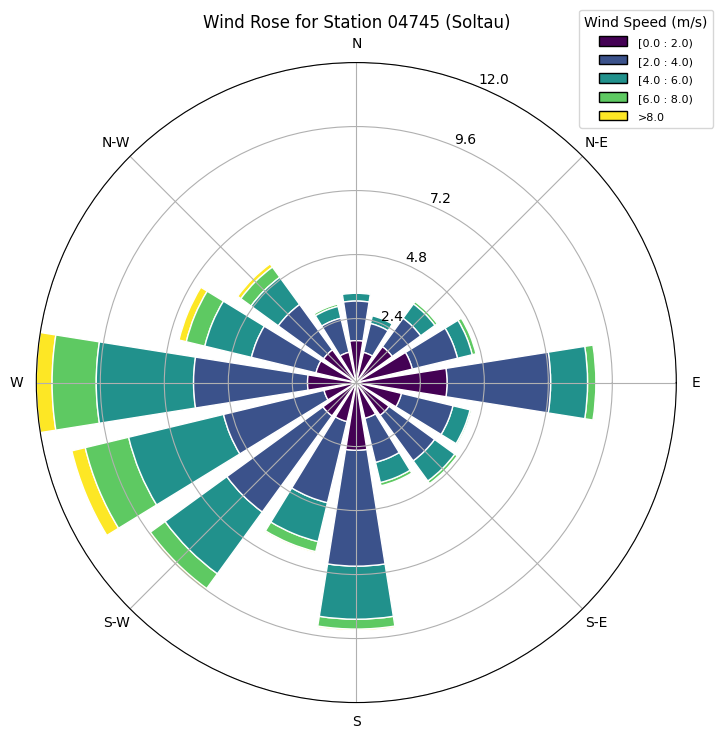

In [17]:

df_reference_wind = df_complete_dataset[
    [reference_wind_direction_column, reference_wind_speed_column]
].dropna()

station_name = df_station_metadata.loc[c.REFERENCE_STATION_ID, "name"]

wind_rose_fig = plt.figure(figsize=(8, 8))
ax = WindroseAxes.from_ax(fig=wind_rose_fig)
ax.bar(
    df_reference_wind[reference_wind_direction_column],
    df_reference_wind[reference_wind_speed_column],
    normed=True,
    opening=0.8,
    edgecolor="white",
    bins=np.arange(0, 10, 2),
)

ax.set_legend(
    bbox_to_anchor=(0.85, 0.9), 
    title="Wind Speed (m/s)"
)

plt.title(f"Wind Rose for Station {c.REFERENCE_STATION_ID} ({station_name})")
plt.savefig("notebooks/plots/wind_rose.png", dpi=300, bbox_inches='tight')
plt.show()

In [18]:
wind_direction_ref = df_reference_wind["wind_direction_04745"]

wind_between_W_S = get_wind_dir_relative_freq(wind_direction_ref, 168.75, 326.25)
print(f"Wind between 168.75° and 326.25°: {wind_between_W_S}")

Wind between 168.75° and 326.25°: 0.6057924056215184


### Determine periodicity of wind speeds at reference station


In [19]:
wind_speeds_at_ref = df_complete_dataset.loc["2021-01-01 00:00:00":"2023-12-31 00:00:00", reference_wind_speed_column]
print(f"Number of NaNs at ref station between 2021-01-01 00:00:00 and 2023-12-31 00:00:00: {wind_speeds_at_ref.isna().sum()}")
percent_nans = (wind_speeds_at_ref.isna().sum() / len(wind_speeds_at_ref)) * 100
print(f"Percentage of NaNs at ref station between 2021-01-01 00:00:00 and 2023-12-31 00:00:00: {percent_nans}")
wind_speeds_at_ref_no_nans = wind_speeds_at_ref.interpolate("linear")
print(f"Number of used samples: {len(wind_speeds_at_ref)}")

Number of NaNs at ref station between 2021-01-01 00:00:00 and 2023-12-31 00:00:00: 47
Percentage of NaNs at ref station between 2021-01-01 00:00:00 and 2023-12-31 00:00:00: 0.02983426115769629
Number of used samples: 157537


In [20]:
dt = 10 * 60
x = wind_speeds_at_ref_no_nans

Y = np.fft.rfft(x)
freqs = np.fft.rfftfreq(len(x), dt)
power = (np.abs(Y) ** 2) / len(x)

idx = np.argsort(power[1:])[-2:] + 1  # +1 restores alignment after discarding bin 0

period_sec = 1 / freqs[idx]
period_hr = period_sec / 3600
period_day = period_hr / 24

top_two_peaks = (
    pd.DataFrame(
        {
            "frequency_Hz": freqs[idx],
            "period_hours": period_hr,
            "period_days": period_day,
            "power": power[idx],
        }
    )
    .sort_values("power", ascending=False)
    .reset_index(drop=True)
)
top_two_peaks.head()


,frequency_Hz,period_hours,period_days,power
0,1.157400e-05,24.000152,1.000006,23668.305335
1,3.173858e-08,8752.055556,364.668981,14901.220046


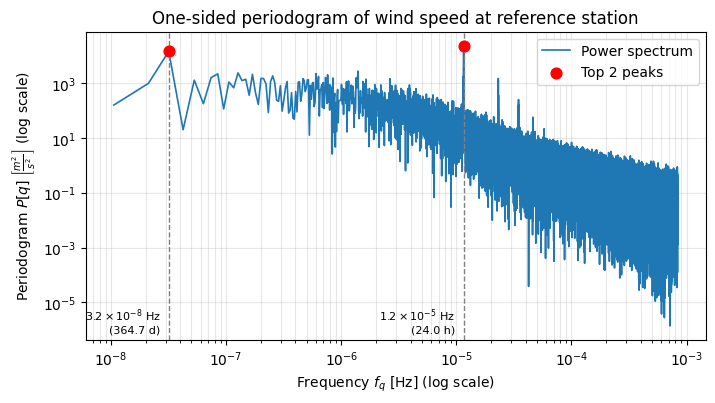

In [21]:
plt.figure(figsize=(8, 4))

plt.loglog(freqs[1:], power[1:], lw=1.2, label="Power spectrum")

plt.scatter(freqs[idx], power[idx], s=60, color="red", zorder=3, label="Top 2 peaks")

for i in idx:
    freq = freqs[i]
    per_sec = 1 / freq
    if per_sec >= 2 * 86400:  # More than 2 days
        period_str = f"{per_sec / 86400:.1f} d"
    elif per_sec >= 2 * 3600:  # More than 2 hours
        period_str = f"{per_sec / 3600:.1f} h"
    else:
        period_str = f"{per_sec / 60:.1f} min"

    exp = int(np.floor(np.log10(freq)))
    base = freq / 10**exp
    freq_str = rf"${base:.1f} \times 10^{{{exp}}}$ Hz"

    plt.axvline(freq, color="gray", linestyle="--", linewidth=1)

    plt.text(
        freq * 0.85,
        plt.ylim()[0] * 1.5,
        f"{freq_str}\n({period_str})",
        ha="right",
        va="bottom",
        fontsize=8,
        color="black",
    )

plt.title("One-sided periodogram of wind speed at reference station")
plt.xlabel(r"Frequency $f_q$ [Hz] (log scale)")
plt.ylabel(r"Periodogram $P[q]$ $\left[\frac{m^{2}}{s^{2}}\right]$ (log scale)")

plt.grid(alpha=0.3, which="both")
plt.legend()
plt.savefig("notebooks/plots/power_spectrum.png", dpi=300, bbox_inches='tight')
plt.show()


## Visualize station locations

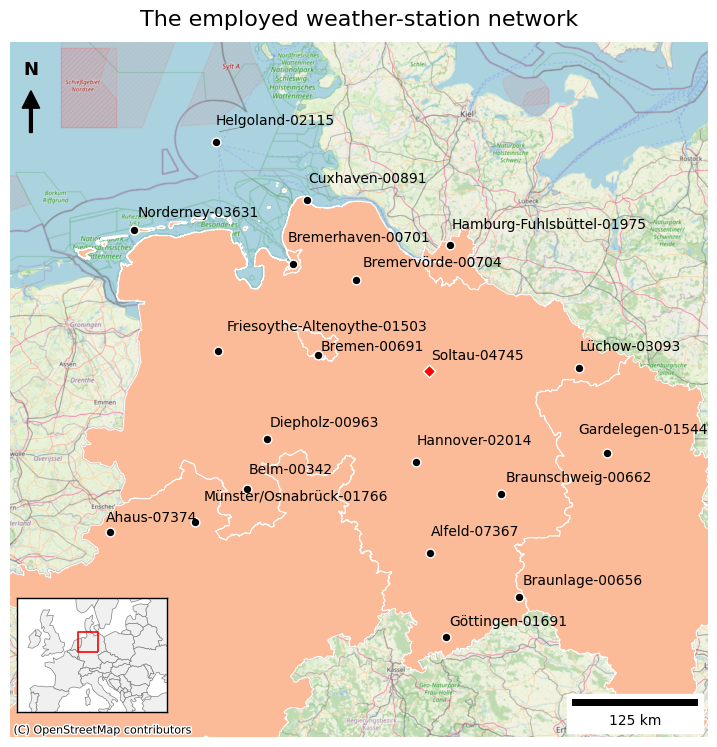

In [22]:
gdf_stations = gpd.GeoDataFrame(
    df_station_metadata,
    geometry=gpd.GeoSeries.from_xy(
        df_station_metadata.geographic_longitude,
        df_station_metadata.geographic_latitude,
    ),
    crs="EPSG:4326",
)

states = gpd.read_file("notebooks/shape_files/gadm41_DEU_shp/gadm41_DEU_1.shp")
target = ["Bremen", "Niedersachsen", "Sachsen-Anhalt", "Nordrhein-Westfalen", "Hamburg"]
gdf_land = states[states.NAME_1.isin(target)]

CRS_WEB = "EPSG:3857"
stations_web = gdf_stations.to_crs(CRS_WEB)
normal_stations = gdf_stations[gdf_stations.index != c.REFERENCE_STATION_ID].to_crs(CRS_WEB)
ref_station = gdf_stations.loc[[c.REFERENCE_STATION_ID]].to_crs(CRS_WEB)
land_web = gdf_land.to_crs(CRS_WEB)

fig, ax = plt.subplots(figsize=(9, 10))

xmin, ymin, xmax, ymax = stations_web.total_bounds
buffer = 100000
ax.set_xlim(xmin - buffer, xmax + buffer)
ax.set_ylim(ymin - buffer, ymax + buffer)


cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, zoom=8)

land_web.plot(ax=ax, facecolor="#FBBB98", edgecolor="white", linewidth=0.8, zorder=2)

normal_stations.plot(ax=ax, color="black", edgecolor="white", markersize=40, marker="o", zorder=3)
ref_station.plot(ax=ax, color="red", edgecolor="white", markersize=40, marker="D", zorder=4)

texts = []
for geom, name, id in zip(stations_web.geometry, gdf_stations["name"], gdf_stations.index):
    texts.append(
        ax.annotate(
            f"{name}-{id}",
            xy=(geom.x, geom.y),
            xytext=(geom.x, geom.y + 10000) if name != "Gardelegen" else (geom.x, geom.y + 15000),
            fontsize=10,
            ha="left",
            va="bottom",
            zorder=4,
        )
    )
adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="->", color="gray", lw=0.5))

scalebar = ScaleBar(
    1,
    units="m",
    length_fraction=0.20,
    location="lower right",
    pad=0.4,
    border_pad=0.3,
    color="black",
    frameon=True,
)
ax.add_artist(scalebar)

ax.annotate(
    "N",
    xy=(0.03, 0.96),
    xycoords="axes fraction",
    ha="center",
    va="center",
    fontsize=13,
    fontweight="bold",
)
ax.arrow(
    0.03,
    0.87,
    0,
    0.06,
    transform=ax.transAxes,
    width=0.004,
    head_width=0.025,
    head_length=0.025,
    length_includes_head=True,
    color="k",
    zorder=7,
)

ax_in = inset_axes(ax, width=1.5, height=1.5, loc="lower left", borderpad=0.5)

world = gpd.read_file(
    "notebooks/shape_files/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp"
)
world.to_crs(CRS_WEB).plot(ax=ax_in, facecolor="#f0f0f0", edgecolor="gray", linewidth=0.5)

bbox_rect = box(xmin - buffer, ymin - buffer, xmax + buffer, ymax + buffer)
gpd.GeoSeries([bbox_rect], crs=CRS_WEB).boundary.plot(ax=ax_in, edgecolor="red", linewidth=1.2)


ax_in.set_xticks([])
ax_in.set_yticks([])
ax_in.set_xlim(-1.5e6, 3.8e6)
ax_in.set_ylim(4.5e6, 8.5e6)
for spine in ax_in.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.0)

ax.set_title("The employed weather-station network", fontsize=16, pad=12)
ax.set_axis_off()

plt.savefig("notebooks/plots/station_network.png", dpi=300, bbox_inches="tight")

plt.show()

In [23]:
get_stations_in_sec_rel_freq(ref_station, normal_stations, 168.75, 326.25)

Stations in interval (168.75°, 326.25°]: 14
Relative frequency: 73.68%
